In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname("analysis"), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torchaudio
import torch
import librosa
import numpy as np
import pywt
import librosa.display
import matplotlib.gridspec as gridspec
from audiomentations import Normalize
from typing import Tuple
from scipy.fft import rfft, rfftfreq
from scipy import signal
from src.utils import create_propor_train_dataframe
from src.processing import read_audio, stereo_to_mono
from src.features import extract_melspectrogram, extract_wavelet_from_raw_audio

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        
        if xlim:
            axes[c].set_xlim(xlim)
        
        if ylim:
            axes[c].set_ylim(ylim)
            
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
def plot_wavelet(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def torch_to_numpy(
    tensor: torch.Tensor
) -> np.ndarray:
    """
    Converts a torch's tensor to numpy.

    Args:
        tensor (torch.Tensor): torch's tensor.

    Returns:
        np.ndarray: numpy's tensor.
    """
    np_tensor = tensor.detach().permute(1, 0).numpy()
    np_tensor = np_tensor.astype(np.float32)
    return np_tensor

def numpy_to_torch(
    tensor: np.ndarray
) -> torch.Tensor:
    """
    Converts a numpy's tensor to torch.

    Args:
        tensor (np.ndarray): numpy's tensor.

    Returns:
        torch.Tensor: torch's tensor.
    """
    torch_tensor = torch.from_numpy(tensor).permute(1, 0)
    torch_tensor = torch_tensor.to(dtype=torch.float32)
    return torch_tensor

In [3]:
propor_train_path = "/media/greca/HD/Datasets/PROPOR 2022"
propor_train_df = create_propor_train_dataframe(propor_train_path)
propor_train_df["wav_file"] = propor_train_df["wav_file"].apply(lambda x: os.path.join(propor_train_path, x))
propor_train_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,non-neutral-male,/media/greca/HD/Datasets/PROPOR 2022/bpubdl02_...
1,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,/media/greca/HD/Datasets/PROPOR 2022/bpubmn14_...
2,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,/media/greca/HD/Datasets/PROPOR 2022/bfamdl26_...
3,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,/media/greca/HD/Datasets/PROPOR 2022/bfammn27_...
4,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,/media/greca/HD/Datasets/PROPOR 2022/bfamcv02_...


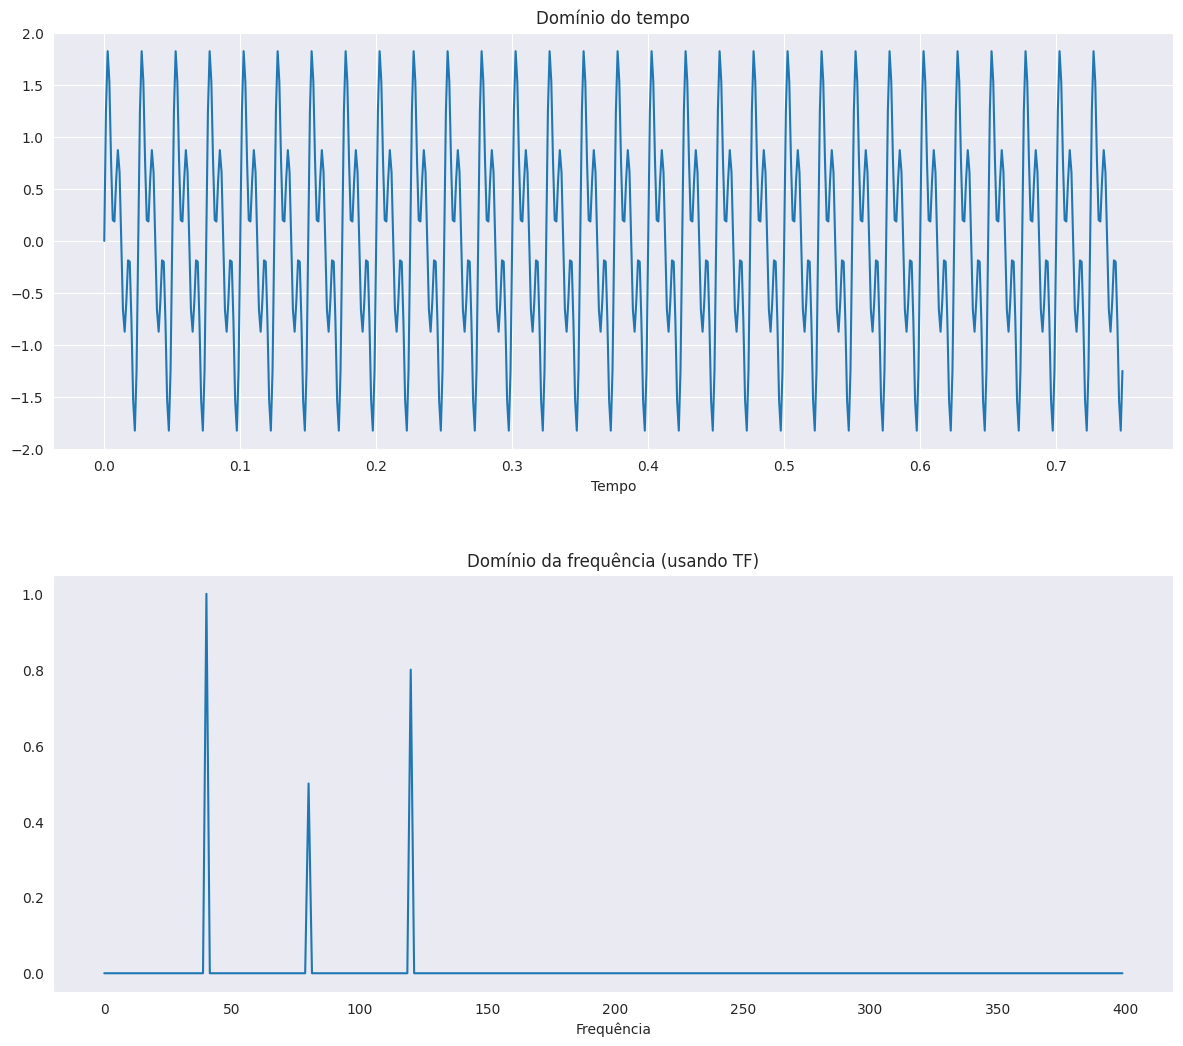

In [4]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(40.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.8*np.sin(120.0 * 2.0*np.pi*x)

yf = rfft(y)
xf = rfftfreq(N, T)[:N//2]

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 12))
ax1.plot(x, y)
ax1.set_xlabel("Tempo")
ax1.set_title("Domínio do tempo", fontsize=12)
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.set_xlabel("Frequência")
ax2.set_title("Domínio da frequência (usando TF)", fontsize=12)

plt.grid()
# plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)
plt.savefig("../images/domínio_tempo_vs_frequência.png")

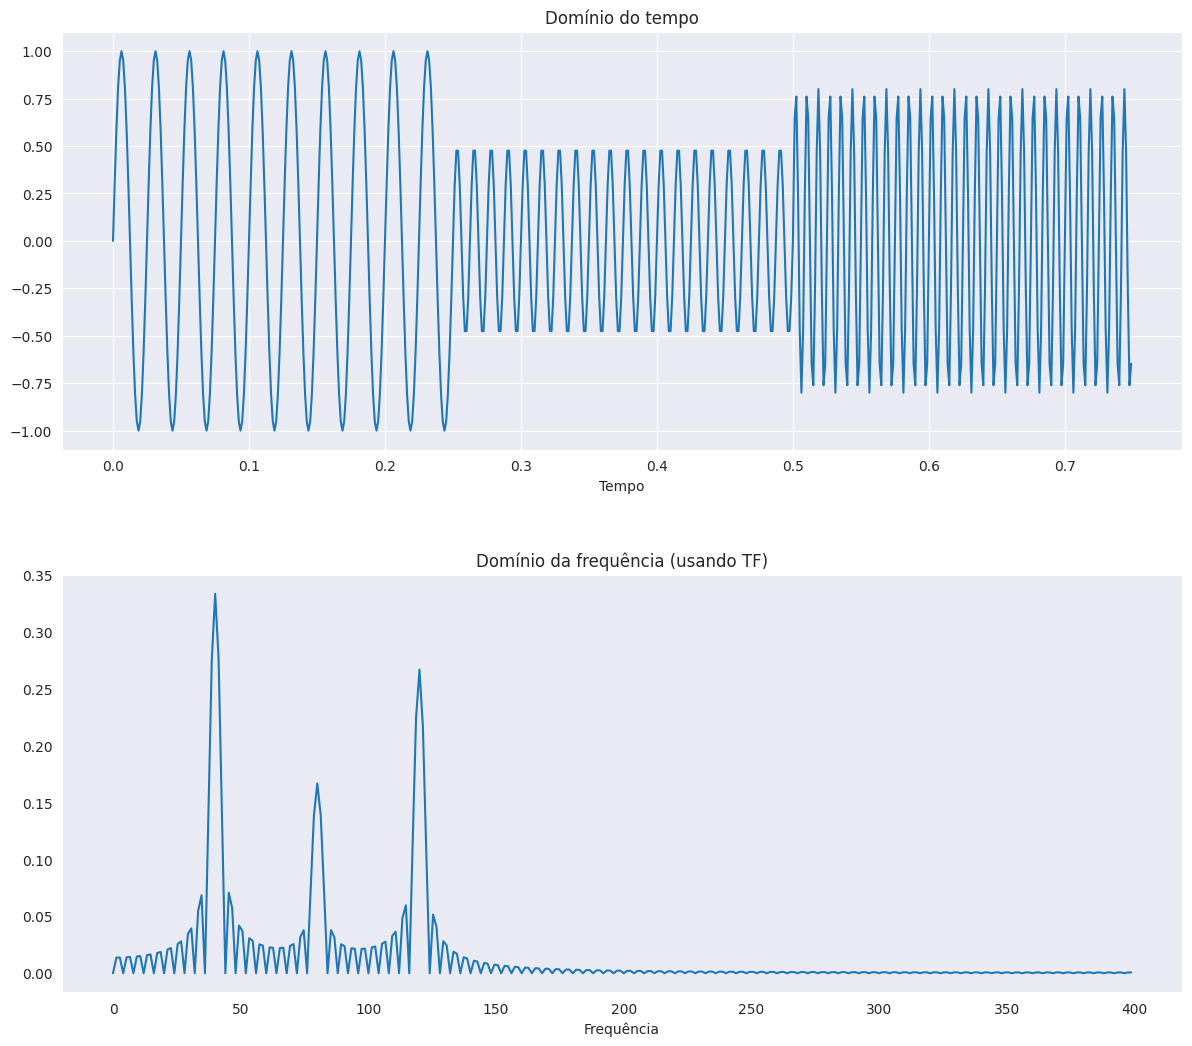

In [5]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N, endpoint=False)
y[:200] = np.sin(40.0 * 2.0*np.pi*x[:200])
y[200:400] = 0.5*np.sin(80.0 * 2.0*np.pi*x[200:400])
y[400:600] = 0.8*np.sin(120.0 * 2.0*np.pi*x[400:600])

yf = rfft(y)
xf = rfftfreq(N, T)[:N//2]

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 12))
ax1.plot(x, y)
ax1.set_xlabel("Tempo")
ax1.set_title("Domínio do tempo", fontsize=12)
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.set_xlabel("Frequência")
ax2.set_title("Domínio da frequência (usando TF)", fontsize=12)

plt.grid()
# plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)
plt.savefig("../images/domínio_tempo_vs_frequência_não-estacionário.png")

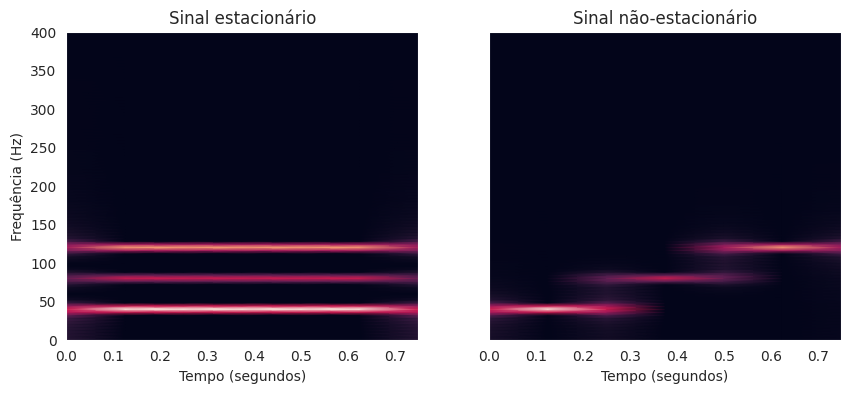

In [6]:
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(40.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) + 0.8*np.sin(120.0 * 2.0*np.pi*x)
n_y = []
fft = 200

n_y[:200] = np.sin(40.0 * 2.0*np.pi*x[:200])
n_y[200:400] = 0.5*np.sin(80.0 * 2.0*np.pi*x[200:400])
n_y[400:600] = 0.8*np.sin(120.0 * 2.0*np.pi*x[400:600])

f, t, Zxx = signal.stft(y, 800, nperseg=fft)
n_f, n_t, n_Zxx = signal.stft(n_y, 800, nperseg=fft)

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
axs[0].set_ylabel("Frequência (Hz)")
axs[0].set_xlabel("Tempo (segundos)")
axs[0].set_title("Sinal estacionário")
axs[1].pcolormesh(n_t, n_f, np.abs(n_Zxx), vmin=0, shading='gouraud')
axs[1].set_xlabel("Tempo (segundos)")
axs[1].set_title("Sinal não-estacionário")

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
plt.savefig("../images/comparação_stft.png")

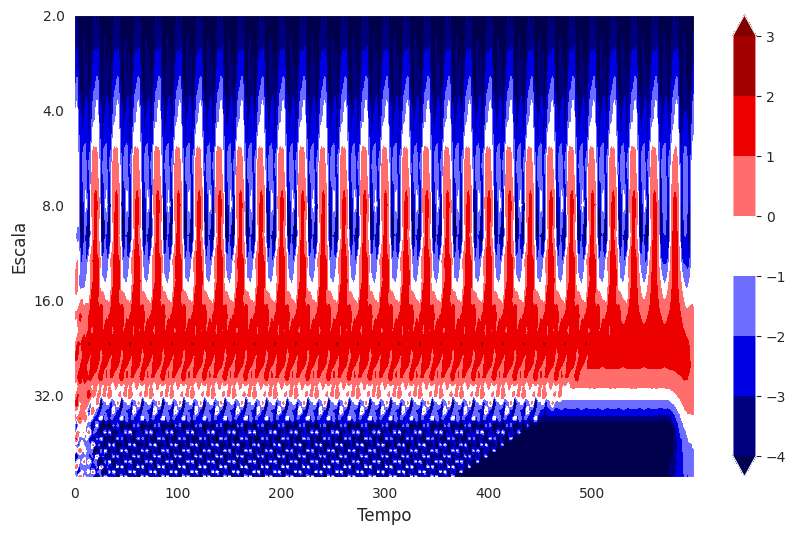

In [7]:
## https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Escala', 
                 xlabel = 'Tempo'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    fig.colorbar(im, orientation="vertical")
    plt.savefig("../images/wavelet.png")
    
N = len(y)
time = np.arange(0, N)
scales = np.arange(1, 30)
plot_wavelet(time, y, scales)

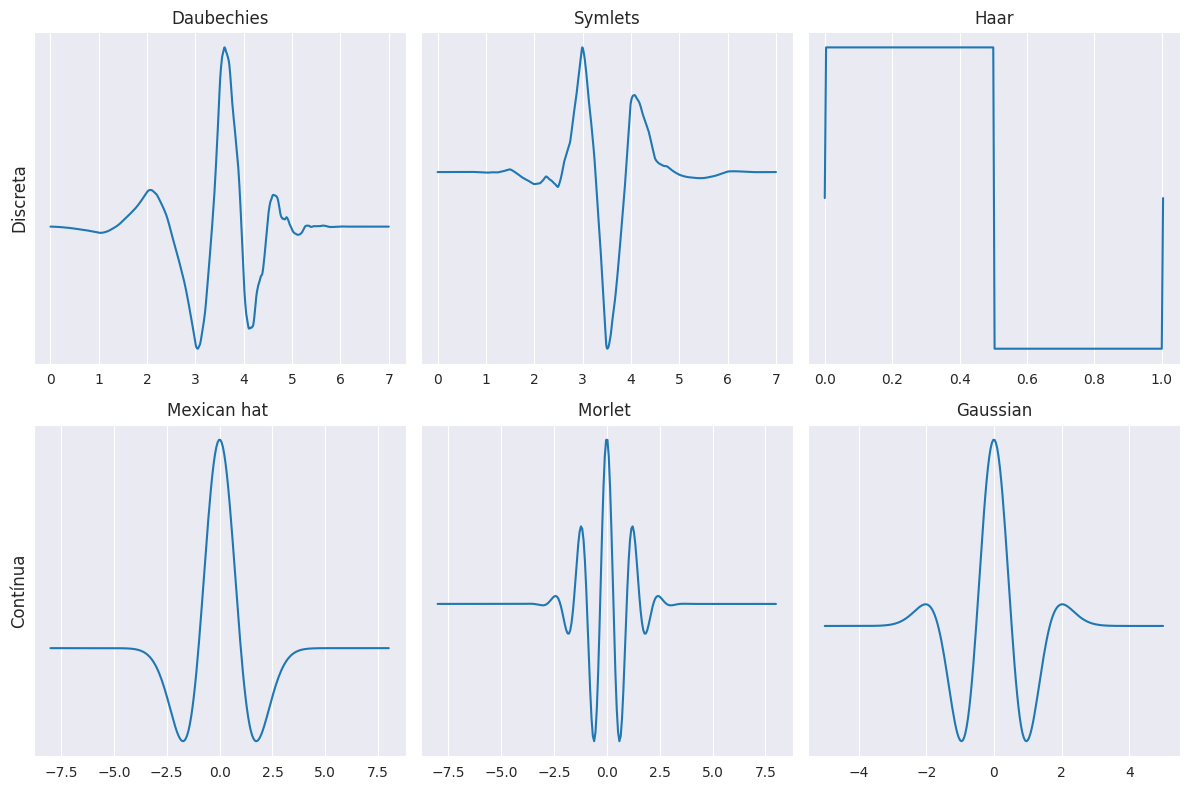

In [8]:
## https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
discrete_wavelets = ['db4', 'sym4', 'haar']
continuous_wavelets = ['mexh', 'morl', 'gaus4']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name.replace("wavelet", "")
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        
        if ii == 0:
            _, wavelet_function, x_values = wavelet.wavefun()
        else:
            wavelet_function, x_values = wavelet.wavefun()
            
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discreta", fontsize=12)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Contínua", fontsize=12)
            
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=12)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.savefig("../images/famílias_wavelet.png")

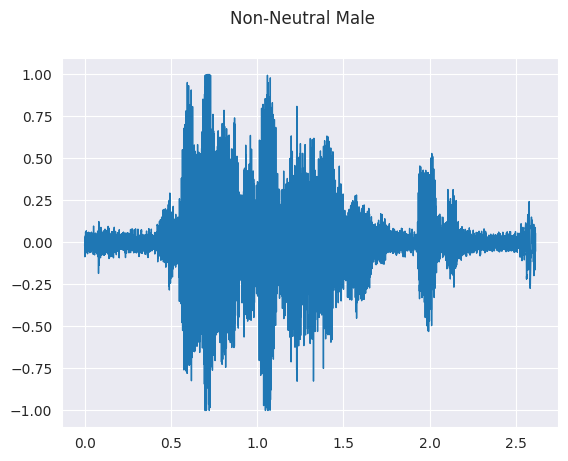

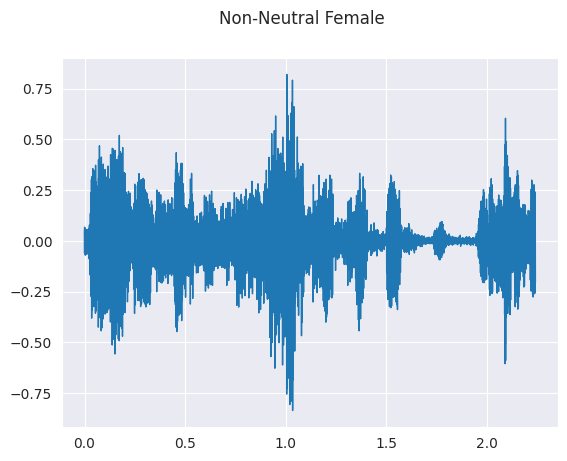

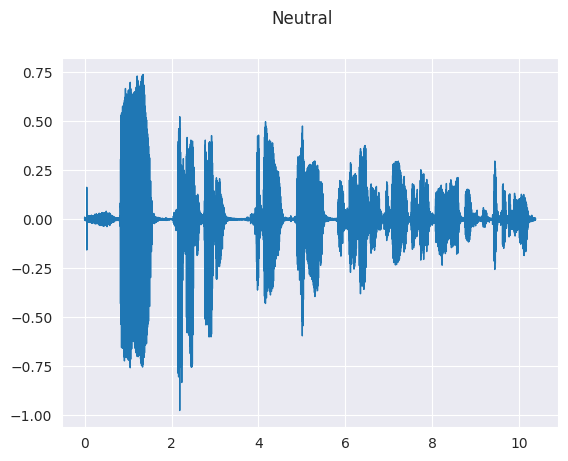

In [9]:
sr = 16000

non_neutral_male_audio, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "non-neutral-male"]["file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)

non_neutral_female_audio, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "non-neutral-female"]["file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)

neutral, _ = read_audio(
    path=propor_train_df[propor_train_df["label"] == "neutral"]["file"].values.tolist()[0],
    to_mono=True,
    sample_rate=sr
)
                                                                                                     
plot_waveform(non_neutral_male_audio, sr, "Non-Neutral Male")
plot_waveform(non_neutral_female_audio, sr, "Non-Neutral Female")
plot_waveform(neutral, sr, "Neutral")

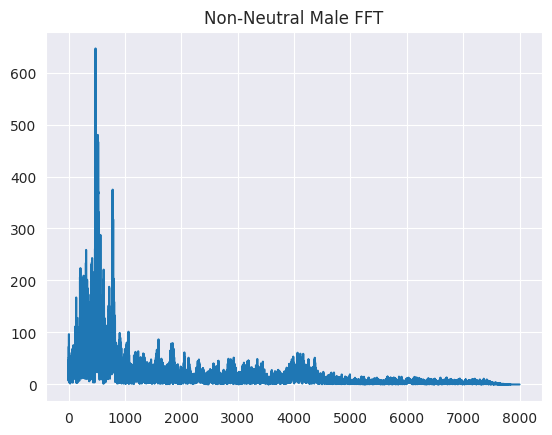

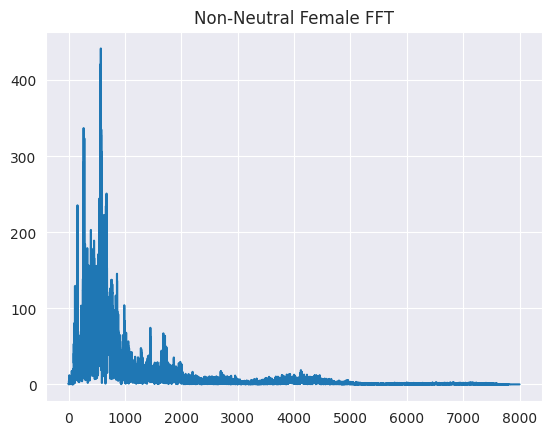

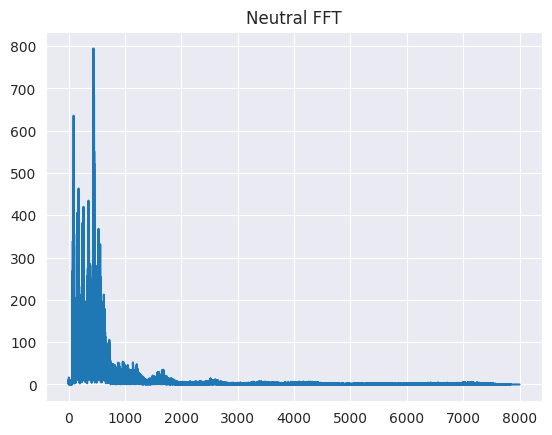

In [10]:
def plot_fft(y, sr, title):
    N = y.shape[0]

    yf = rfft(y)
    xf = rfftfreq(N, 1/sr)

    plt.title(title)
    plt.plot(xf, np.abs(yf))
    plt.show()

sr = 16000
normalizer = Normalize(p=1)

plot_fft(
    normalizer(non_neutral_male_audio.squeeze().numpy(), sr),
    sr,
    "Non-Neutral Male FFT"
)

plot_fft(
    normalizer(non_neutral_female_audio.squeeze().numpy(), sr),
    sr,
    "Non-Neutral Female FFT"
)

plot_fft(
    normalizer(neutral.squeeze().numpy(), sr),
    sr,
    "Neutral FFT"
)

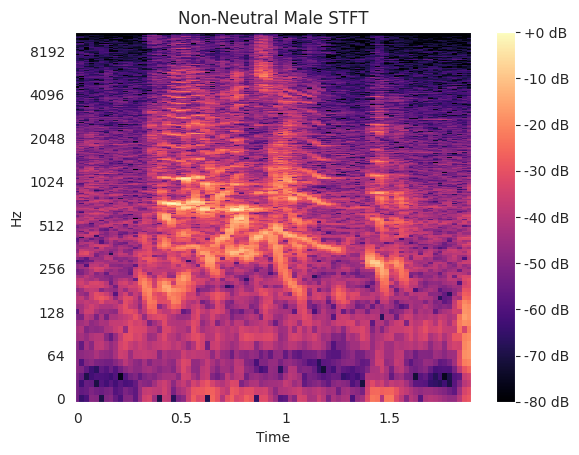

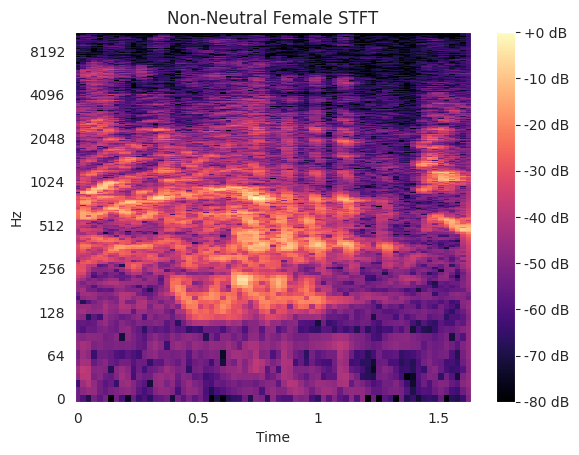

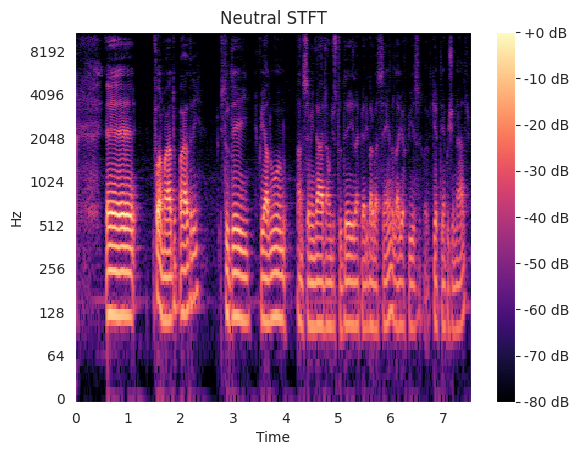

In [11]:
def plot_stft(audio, title):
    fig, ax = plt.subplots()
    S = np.abs(librosa.stft(audio))
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_title(title)
    plt.show()

normalizer = Normalize(p=1)

plot_stft(
    normalizer(non_neutral_male_audio.squeeze().numpy(), sr),
    'Non-Neutral Male STFT'
)

plot_stft(
    normalizer(non_neutral_female_audio.squeeze().numpy(), sr),
    'Non-Neutral Female STFT'
)

plot_stft(
    normalizer(neutral.squeeze().numpy(), sr),
    'Neutral STFT'
)

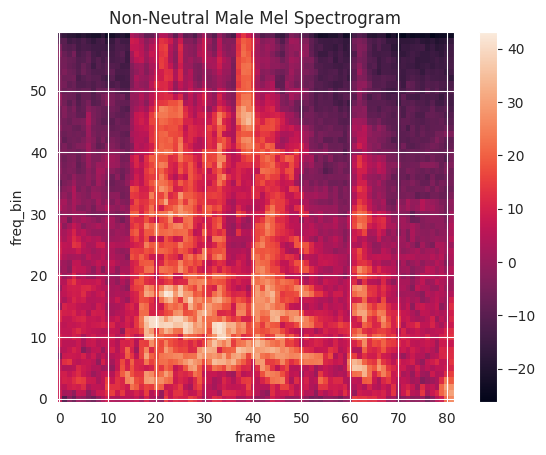

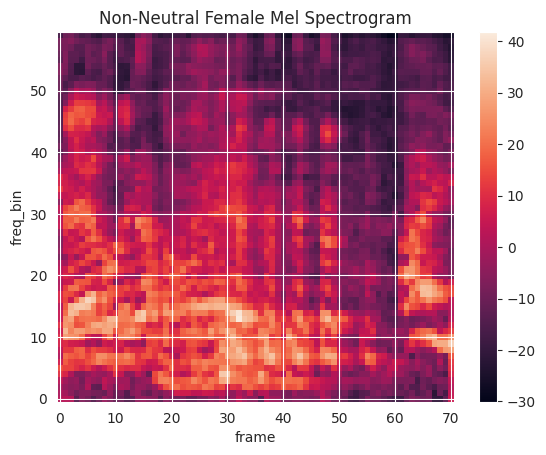

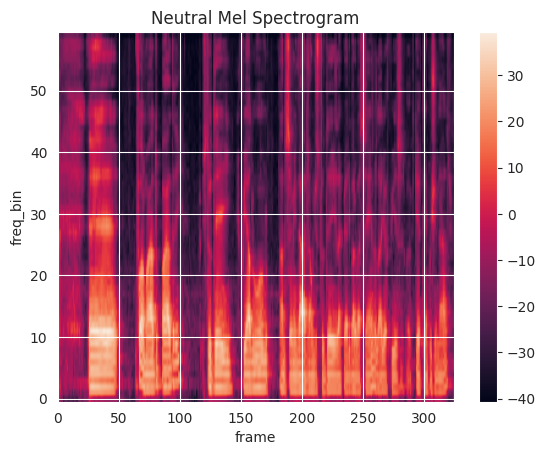

In [12]:
n_fft = 1024
hop_length = 512
n_mels = 60

non_neutral_male_mel_spec = extract_melspectrogram(non_neutral_male_audio, sr, n_fft, hop_length, n_mels).squeeze(0)
non_neutral_female_mel_spec = extract_melspectrogram(non_neutral_female_audio, sr, n_fft, hop_length, n_mels).squeeze(0)
neutral_mel_spec = extract_melspectrogram(neutral, sr, n_fft, hop_length, n_mels).squeeze(0)

plot_spectrogram(
    non_neutral_male_mel_spec,
    "Non-Neutral Male Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

plot_spectrogram(
    non_neutral_female_mel_spec,
    "Non-Neutral Female Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

plot_spectrogram(
    neutral_mel_spec,
    "Neutral Mel Spectrogram",
    "freq_bin",
    "auto",
    None
)

In [13]:
import torch
import torch.nn.functional as F
import torchaudio
import webrtcvad
import collections
import numpy as np
import math
from torchaudio.functional import vad
from typing import List

def apply_vad(
    audio: torch.Tensor,
    sample_rate: int
) -> torch.Tensor:
    """
    Attempt to trim silence and quiet background sounds from the audio
    using the default Voice Activity Detection (VAD) from torch.
    
    Args:
        audio (torch.Tensor): the audio's waveform.
        sample_rate (int): the audio's sample rate.
    
    Returns:
        torch.Tensor: the audio's waveform trimmed.
    """
    audio = vad(waveform=audio, sample_rate=sample_rate)
    return audio

class Frame(object):
    """
    Represents a "frame" of audio data.
    """
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def apply_webrtc_vad(
    audio: torch.Tensor,
    sample_rate: int,
    frame_size: int = 30,
    vad_mode: int = 3
) -> torch.Tensor:
    """
    Attempt to trim silence and quiet background sounds from the audio
    using WebRTC's Voice Activity Detection (VAD).
    
    Code taken from https://github.com/wiseman/py-webrtcvad/blob/master/example.py

    Args:
        audio (torch.Tensor): the audio's waveform.
        sample_rate (int): the audio's sample rate.
        frame_size (int, optional): the frame size in ms. Defaults to 30.
        vad_mode (int, optional): the webrtc's vad mode (0 to 3). Defaults to 2.

    Returns:
        torch.Tensor: the audio's waveform trimmed.
    """
    def frame_generator(
        frame_duration_ms,
        audio,
        sample_rate
    ):
        """
        Generates audio frames from PCM audio data.
        Takes the desired frame duration in milliseconds, the PCM data, and
        the sample rate.
        Yields Frames of the requested duration.
        """
        n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
        offset = 0
        timestamp = 0.0
        duration = (float(n) / sample_rate) / 2.0
        while offset + n < len(audio):
            yield Frame(audio[offset:offset + n], timestamp, duration)
            timestamp += duration
            offset += n
    
    def vad_collector(
        sample_rate,
        frame_duration_ms,
        padding_duration_ms,
        vad,
        frames
    ):
        """
        Filters out non-voiced audio frames.
        Given a webrtcvad.Vad and a source of audio frames, yields only
        the voiced audio.
        Uses a padded, sliding window algorithm over the audio frames.
        When more than 90% of the frames in the window are voiced (as
        reported by the VAD), the collector triggers and begins yielding
        audio frames. Then the collector waits until 90% of the frames in
        the window are unvoiced to detrigger.
        The window is padded at the front and back to provide a small
        amount of silence or the beginnings/endings of speech around the
        voiced frames.
        
        Arguments:
            sample_rate - The audio sample rate, in Hz.
            frame_duration_ms - The frame duration in milliseconds.
            padding_duration_ms - The amount to pad the window, in milliseconds.
            vad - An instance of webrtcvad.Vad.
            frames - a source of audio frames (sequence or generator).
        
        Returns:
            torch.Tensor: the new audio's trimmed waveform.
        """
        num_padding_frames = int(padding_duration_ms / frame_duration_ms)
        # We use a deque for our sliding window/ring buffer.
        ring_buffer = collections.deque(maxlen=num_padding_frames)
        # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
        # NOTTRIGGERED state.
        triggered = False
        ts_speech, ts_silence = [], []

        voiced_frames = []
        for frame in frames:
            is_speech = vad.is_speech(frame.bytes, sample_rate)

            if not triggered:
                ring_buffer.append((frame, is_speech))
                num_voiced = len([f for f, speech in ring_buffer if speech])
                # If we're NOTTRIGGERED and more than 90% of the frames in
                # the ring buffer are voiced frames, then enter the
                # TRIGGERED state.
                if num_voiced > 0.9 * ring_buffer.maxlen:
                    triggered = True
                    ts_speech.append(ring_buffer[0][0].timestamp)
                    ring_buffer.clear()
            else:
                # We're in the TRIGGERED state, so collect the audio data
                # and add it to the ring buffer.
                voiced_frames.append(frame)
                ring_buffer.append((frame, is_speech))
                num_unvoiced = len([f for f, speech in ring_buffer if not speech])
                # If more than 90% of the frames in the ring buffer are
                # unvoiced, then enter NOTTRIGGERED and yield whatever
                # audio we've collected.
                if num_unvoiced > 0.9 * ring_buffer.maxlen:
                    triggered = False
                    ts_silence.append(frame.timestamp + frame.duration)
                    ring_buffer.clear()
                    
        if triggered:
            ts_silence.append(ring_buffer[0][0].timestamp)
        
        if ts_silence[0] < ts_speech[0]:
            ts_silence.pop(0)
        
        if len(ts_speech) > 0 and len(ts_silence) > 0:
            new_audio = np.array([])
            
            for bos, eos in zip(ts_speech, ts_silence):
                bos -= padding_duration_ms / 2 / 1000.0
                eos -= padding_duration_ms / 2 / 1000.0
                
                bos = max(math.floor(bos * sample_rate), 0)
                eos = math.ceil(eos * sample_rate)
                
                if new_audio.ndim == 0:
                    new_audio = audio[bos:eos]
                else:
                    new_audio = np.concatenate([new_audio, audio[bos:eos]], axis=0)       
            
            return new_audio
        else:
            return audio
            
    audio = audio.detach().squeeze().numpy().astype(np.float32)
    vad = webrtcvad.Vad(vad_mode)
    frames = frame_generator(frame_size, audio, sample_rate)
    frames = list(frames)
    new_audio = vad_collector(sample_rate, frame_size, 300, vad, frames)
    new_audio = torch.from_numpy(new_audio).to(dtype=torch.float32)
    new_audio = new_audio.unsqueeze(0)
    return new_audio

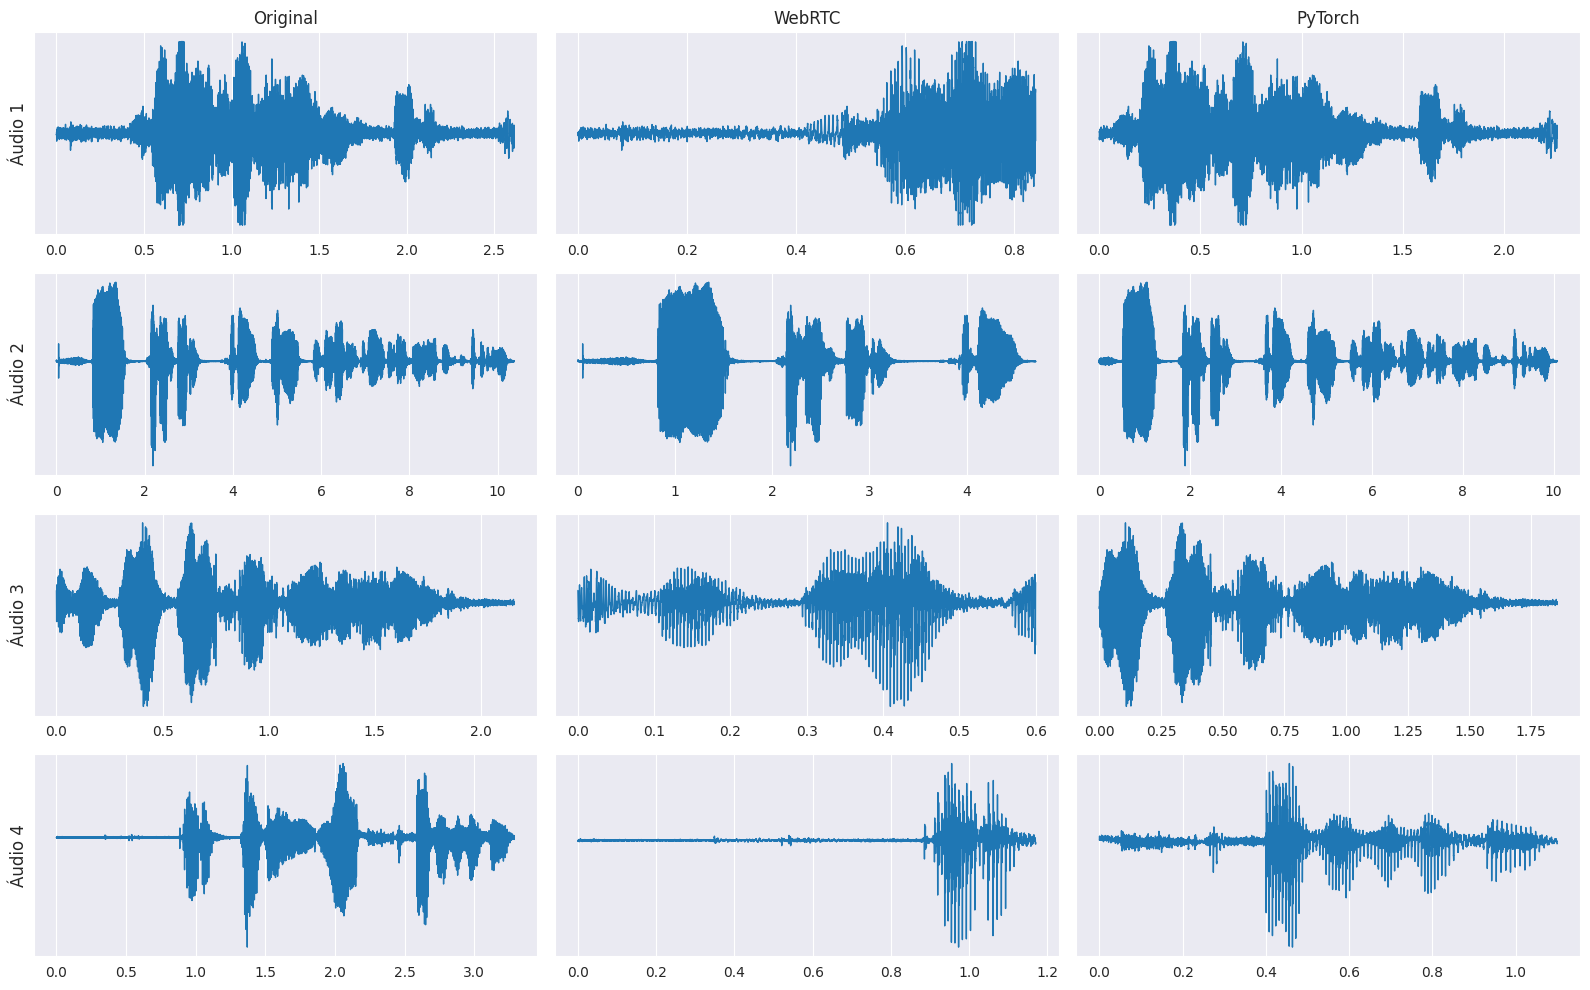

In [14]:
titles = ['Original', 'WebRTC', 'PyTorch']
list_audios = [0, 1, 2, 3]
list_functions = [None, apply_webrtc_vad, apply_vad]

fig, axarr = plt.subplots(nrows=len(list_audios), ncols=3, figsize=(16, 10))

for ii, file in enumerate(list_audios):
    row_no = ii
    
    for col_no, mode_name in enumerate(titles):
        audio, _ = read_audio(
            path=propor_train_df["file"].values.tolist()[file],
            to_mono=True,
            sample_rate=sr
        )
        func = list_functions[col_no]
        
        if func != None:
            audio = func(audio, sr)
                        
        if ii == 0:
            axarr[row_no, col_no].set_title("{}".format(mode_name), fontsize=12)
            
        if col_no == 0:
            axarr[row_no, col_no].set_ylabel(f"Áudio {row_no+1}", fontsize=12)
        
        audio = audio.numpy()

        _, num_frames = audio.shape
        time_axis = torch.arange(0, num_frames) / sr

        axarr[row_no, col_no].plot(time_axis, audio[0], linewidth=1)
        axarr[row_no, col_no].grid(True)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.savefig("../images/experimento_vad.png")

In [15]:
import argparse
import os
import json
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from src.utils import read_feature, choose_model
from src.dataset import create_dataloader
from typing import Dict

def test(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    dataset: str
) -> Dict:
    """
    Function responsible for the model testing in the test dataset.

    Args:
        model (nn.Module): the created model.
        dataloader (DataLoader): the test dataloader.
        device (torch.device): which device to use.
        dataset (str): which dataset is being used ('coraa', 'emodb', 'ravdess').

    Returns:
        Dict: the test metrics score.
    """
    model.eval()
    predictions = []
    targets = []
    
    with torch.inference_mode():
        for batch in dataloader:
            data = batch["features"].to(device)
            target = batch["labels"].to(device)

            data = data.to(dtype=torch.float32)
            target = target.to(dtype=torch.float32)
            
            output = model(data)
            
            # prediction = output.argmax(dim=-1, keepdim=True).to(dtype=torch.int)
            prediction = output.detach().cpu().numpy()
            predictions.extend(prediction.tolist())
            
            #  target = target.argmax(dim=-1, keepdim=True).to(dtype=torch.int)
            target = target.detach().cpu().numpy()
            targets.extend(target.tolist())
    
    roc_auc = roc_auc_score(
        y_true=targets,
        y_score=predictions,
        average="macro",
        multi_class="ovr"
    )
    
    predictions = torch.Tensor(predictions).argmax(dim=-1, keepdim=True).to(dtype=torch.int)
    predictions = predictions.numpy().tolist()
    
    targets = torch.Tensor(targets).argmax(dim=-1, keepdim=True).to(dtype=torch.int)
    targets = targets.numpy().tolist()
    
    f1_score = classification_report(
        y_true=targets,
        y_pred=predictions,
        digits=4,
        output_dict=True,
        zero_division=0.0
    )["macro avg"]["f1-score"]
    
    accuracy = accuracy_score(
        y_true=targets, 
        y_pred=predictions
    )
    
    targets = np.array(targets).reshape(-1).tolist()
    predictions = np.array(predictions).reshape(-1).tolist()
    
    if dataset == "propor2022":
        map_labels = {
            0: "neutro",
            1: "homem não-neutro",
            2: "mulher não-neutro"
        }
        
        labels = ["neutro", "homem não-neutro", "mulher não-neutro"]
    elif dataset == "emodb":
        map_labels = {
            0: "neutro",
            1: "raiva",
            2: "tédio",
            3: "nojo",
            4: "medo",
            5: "felicidade",
            6: "tristeza"
        }
        
        labels = ["neutro", "raiva", "tédio", "nojo", "medo", "felicidade", "tristeza"]
    elif dataset == "ravdess":
        map_labels = {
            0: "neutro",
            1: "raiva",
            2: "calmo",
            3: "nojo",
            4: "medo",
            5: "felicidade",
            6: "tristeza",
            7: "surpresa"
        }
        
        labels = ["neutro", "raiva", "calmo", "nojo", "medo", "felicidade", "tristeza", "surpresa"]
    elif dataset == "savee":
        map_labels = {
            0: "neutro",
            1: "raiva",
            2: "nojo",
            3: "medo",
            4: "felicidade",
            5: "tristeza",
            6: "surpresa"
        }
        
        labels = ["neutro", "raiva", "nojo", "medo", "felicidade", "tristeza", "surpresa"]
            
    new_targets = [map_labels[t] for t in targets]
    new_predictions = [map_labels[p] for p in predictions]
    
    cm = confusion_matrix(
        y_true=new_targets,
        y_pred=new_predictions,
        labels=labels
    )
    
    metrics = {
        "f1-score macro": f1_score,
        "unweighted accuracy": accuracy,
        "roc-auc macro": roc_auc,
        "confusion_matrix": cm,
        "labels": labels
    }
    
    return metrics

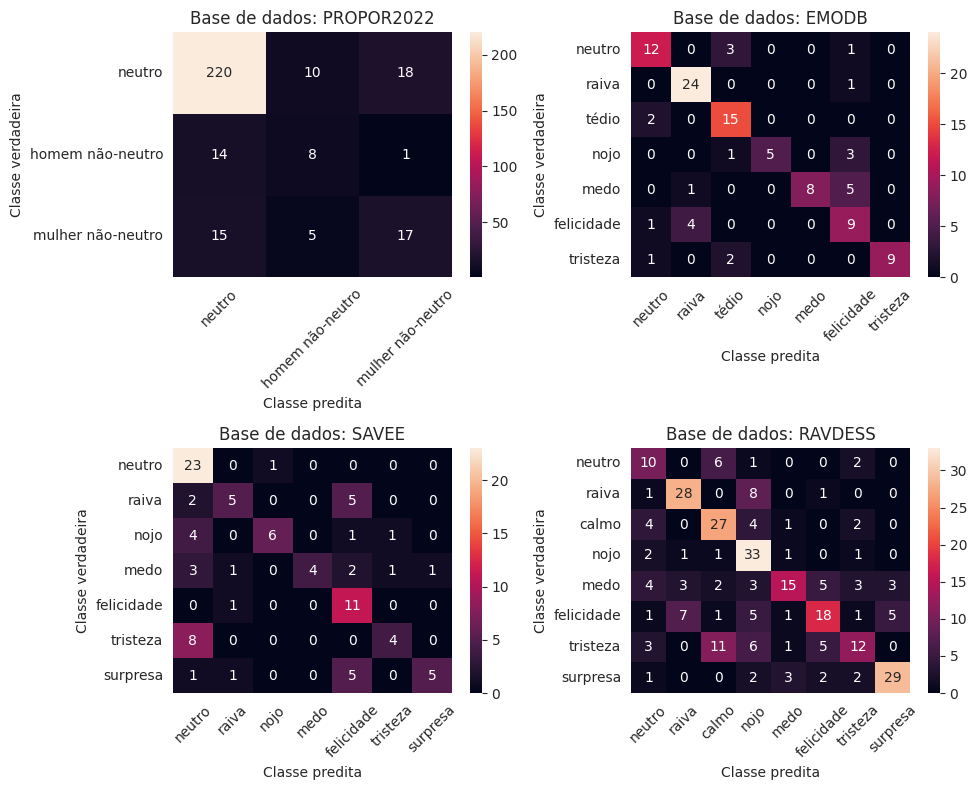

In [16]:
k_fold = None
output_path = "../test_checkpoints/"
model_name = "cnn3"
use_gpu = True
device = torch.device("cuda") if use_gpu else torch.device("cpu")

datasets = ["propor2022", "emodb", "savee", "ravdess"]
conf_matrixes = []
labels = []

feat_config = {
    "name": "mel_spectrogram",
    "n_fft": 400,
    "hop_length": 200,
    "n_mels": 128,
    "f_min": 0,
    "f_max": 4000,
    "sample_rate": 8000
}

wavelet_config = {
    "type": "dwt",
    "name": "db4",
    "level": 3,
    "mode": "symmetric"
}

for dataset in datasets:
    if dataset == "propor2022":
        max_seconds = 16
    elif dataset == "emodb":
        max_seconds = 10
    elif dataset == "ravdess":
        max_seconds = 6
    
    feat_path = os.path.join(output_path, dataset)
        
    # reading training audio features
    if dataset == "propor2022":
        X_test = read_feature(
            path=feat_path,
            name="X_test.pth",
        )

        y_test = read_feature(
            path=feat_path,
            name="y_test.pth",
        )
    else:
        X_test = read_feature(
            path=feat_path,
            name="X_valid.pth",
        )

        y_test = read_feature(
            path=feat_path,
            name="y_valid.pth",
        )
    
    model = choose_model(
        mode="mode_1",
        model_name=model_name,
        device=device,
        dataset=dataset
    )
    
    # creating the test dataloader
    test_dataloader = create_dataloader(
        X=X_test,
        y=y_test,
        feature_config=feat_config,
        wavelet_config=wavelet_config,
        data_augmentation_config=None,
        num_workers=0,
        mode="mode_1",
        shuffle=False,
        training=False,
        batch_size=16,
        data_augment_target=None
    )
    
    # loading the trained model parameters
    model.load_state_dict(
        torch.load(
            os.path.join(output_path, dataset, "mode_1", model_name, f"{model_name}.pth")
        )["model_state_dict"]
    )
    
    scores = test(
        model=model,
        dataloader=test_dataloader,
        device=device,
        dataset=dataset
    )
    
    conf_matrixes.append(scores["confusion_matrix"])
    labels.append(scores["labels"])

fig, axs = plt.subplots(nrows=len(datasets)//2, ncols=len(datasets)//2, figsize=(10, 8))
j, k = 0, 0

for i, cm in enumerate(conf_matrixes):
    if i == 2:
        j = 1
        k = 0
    
    sns.heatmap(cm, annot=True, fmt='g', ax=axs[j, k])
    
    # labels, title and ticks
    axs[j, k].set_xlabel("Classe predita")
    axs[j, k].set_ylabel("Classe verdadeira")
    axs[j, k].set_title(f"Base de dados: {datasets[i].upper()}")
    axs[j, k].xaxis.set_ticklabels(labels[i], rotation=45)
    axs[j, k].yaxis.set_ticklabels(labels[i], rotation=360)
    
    k += 1

plt.tight_layout()
plt.savefig("../images/matrizes_confusao.png")